# RESCUE
*Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3.

Characteristics includes:
1. Weather, time and recent errors aware.
2. Correlation aware as solar,wind, and load errors are co-trained.
3. Produces multiple prediction intervals for expected error in netload forecasting
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast

Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian, Huai Jiang


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Load and prepare net load forecast error data

TODO: Proper generalization
TODO: Proper CV
TODO: Basic Data check and Assertion

In [2]:


trainval_input = pd.read_pickle(os.path.join('outputs_from_code','trainval_inputs.pkl')).T
trainval_input = (trainval_input-trainval_input.min())/(trainval_input.max()-trainval_input.min())
# trainval_output = pd.read_pickle(os.path.join('outputs_from_code','trainval_output.pkl')).T
# trainval_output = (trainval_output-trainval_output.min())/(trainval_output.max()-trainval_output.min())
trainval_output = np.random.random(trainval_input.shape[0])-0.5

x_train, x_test = trainval_input.iloc[:90000].values.astype('float32'), trainval_input.iloc[90000:].values.astype('float32')
y_train, y_test = trainval_output[:90000].astype('float32'), trainval_output[90000:].astype('float32')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(90000, 21)
(90000,)
(11185, 21)


Use `tf.data` to batch and shuffle the dataset:

In [12]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

Build the ANN model with Pinball loss using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing)

In [6]:
class ANN_Pinball(tf.keras.Model):
    '''
    A two-layer ANN model with a pinball loss to produce prediction interval.
    The model can take an arbitrary amounts of input. As a rule of thumb less than 100 input terms would be preferred.
    The model's target/label should be the true value of the prediction whose upper/lower bound we are interested in. 
    In our application, since we are interested in the range of forecast erros, the label should be the forecast error.
    
    '''
    def __init__(self):
        super(ANN_Pinball, self).__init__()
        self.d1 = tf.keras.layers.Dense(10, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='relu')
        self.d3 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

# # Create an instance of the model
rescue_model = ANN_Pinball()

# Define the pinball loss function 
def pinball_loss(y_true, y_pred):
    tau = 0.25
    err = y_true - y_pred
    return tf.keras.backend.mean(tf.keras.backend.maximum(tau * err, (tau - 1) * err), axis=-1)

rescue_model.compile(loss=pinball_loss, optimizer=tf.keras.optimizers.Adam(0.001))

Training the rescue model

In [8]:
history = rescue_model.fit(x_train, y_train, epochs=5)

Train on 90000 samples
Epoch 1/5
90000/90000 [==============================] - 4s 41us/sample - loss: 0.0952
Epoch 2/5
90000/90000 [==============================] - 3s 39us/sample - loss: 0.0941
Epoch 3/5
90000/90000 [==============================] - 4s 39us/sample - loss: 0.0941
Epoch 4/5
90000/90000 [==============================] - 4s 45us/sample - loss: 0.0940
Epoch 5/5
90000/90000 [==============================] - 4s 47us/sample - loss: 0.0940


Evaluate on the testing data set

In [11]:
y_pred = rescue_model.predict(x_test)

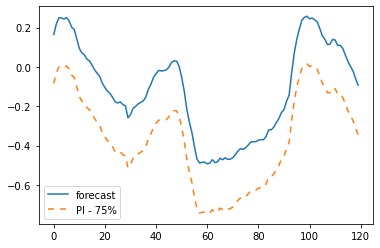

In [10]:
net_load_test = x_test[:,3] - x_test[:,7] - x_test[:,11]

fig,ax = plt.subplots()

ax.plot(net_load_test[:120], label = 'forecast')
ax.plot(net_load_test[:120]+ y_pred[:120,0], label = 'PI - 75%', dashes = [4,4])
ax.legend()

plt.show()

Choose an optimizer and loss function for training: 

In [6]:


# def pinball_loss(labels, predictions):
#     tau = 0.25
#     err = labels - predictions
#     return tf.keras.backend.mean(tf.keras.backend.maximum(tau * err, (tau - 1) * err), axis=-1)

# #loss_object = pinball_loss
# loss_object = tf.keras.losses.MSE

# optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
# @tf.function
# def train_step(images, labels):
#   with tf.GradientTape() as tape:
#     # training=True is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = rescue(images, training=True)
#     loss = loss_object(labels, predictions)
#   gradients = tape.gradient(loss, rescue.trainable_variables)
#   optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

#   train_loss(loss)
#   #train_accuracy(labels, predictions)


# @tf.function
# def test_step(images, labels):
#   # training=False is only needed if there are layers with different
#   # behavior during training versus inference (e.g. Dropout).
#   predictions = rescue(images, training=False)
#   t_loss = loss_object(labels, predictions)

#   test_loss(t_loss)
#   #test_accuracy(labels, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for images, labels in train_ds:
#     train_step(images, labels)

#   for test_images, test_labels in test_ds:
#     test_step(test_images, test_labels)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
